# Task 2. Named entity recognition + image classification

In this notebook, we build a multimodal ML pipeline that:
1. Trains an **NER model** to detect animal names in text.
2. Trains an **Image Classification model** to recognize animals in images.
3. Combines both models into a **pipeline** that checks if the user's text matches the content of the image.

## Dataset Setup

We use the **Animals-10 dataset** from Kaggle, which contains 10 animal categories.  
Steps:
- Install Kaggle API
- Download the dataset
- Extract the images

In [ ]:
# Install & setup Kaggle API
!pip install -q kaggle

# upload kaggle.json
from google.colab import files
files.upload()

!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download Animals-10
!kaggle datasets download -d alessiocorrado99/animals10
!unzip animals10.zip -d  animals10

## Install Dependencies

We install the required libraries:  
- `torch`, `torchvision` - for image classification   
- `PIL` - for image processing  
- `matplotlib`/`pandas` - for data visualization and EDA

In [2]:
# Setup
!pip install -q torch torchvision transformers datasets

In [3]:
#Imports
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

## Exploratory Data Analysis

Before training, let us take a quick look at the dataset:
- It contains **10 animal classes**.  
- The dataset is balanced with several thousand images per class.  
- Below we visualize a few random examples from the dataset.

In [4]:
import os, random
data_dir = "animals10/raw-img"
classes = os.listdir(data_dir)

print("Classes:", classes)

Classes: ['ragno', 'cane', 'mucca', 'farfalla', 'gatto', 'gallina', 'pecora', 'scoiattolo', 'elefante', 'cavallo']


The **Animals-10 dataset** contains 10 animal classes.  
The original labels are in **Italian**, so we map them to **English** for consistency with the NER model.

- scoiattolo → squirrel  
- pecora → sheep  
- cane → dog  
- ragno → spider  
- gallina → chicken  
- mucca → cow  
- gatto → cat  
- cavallo → horse  
- farfalla → butterfly  
- elefante → elephant

In [5]:
# Mapping Italian → English
mapping = {
    "scoiattolo": "squirrel",
    "pecora": "sheep",
    "cane": "dog",
    "ragno": "spider",
    "gallina": "chicken",
    "mucca": "cow",
    "gatto": "cat",
    "cavallo": "horse",
    "farfalla": "butterfly",
    "elefante": "elephant"
}
classes_en = [mapping[c] for c in classes]

print("Original class names (IT):", classes)
print("Mapped class names (EN):", classes_en)

Original class names (IT): ['ragno', 'cane', 'mucca', 'farfalla', 'gatto', 'gallina', 'pecora', 'scoiattolo', 'elefante', 'cavallo']
Mapped class names (EN): ['spider', 'dog', 'cow', 'butterfly', 'cat', 'chicken', 'sheep', 'squirrel', 'elephant', 'horse']


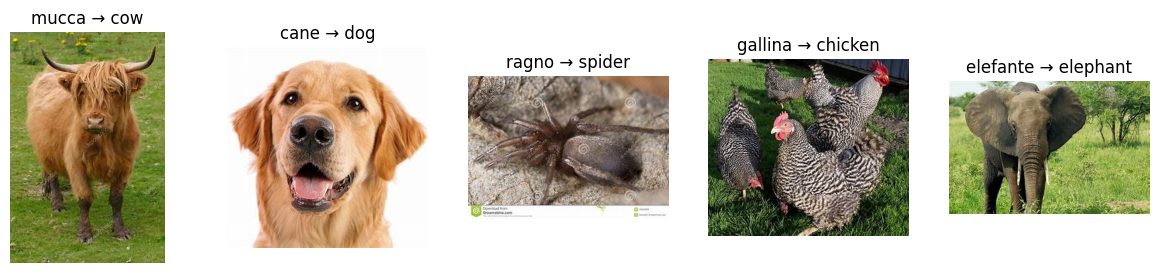

In [6]:
# Show random samples
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for ax in axes:
    cls = random.choice(classes)
    img_path = os.path.join(data_dir, cls, random.choice(os.listdir(os.path.join(data_dir, cls))))
    img = Image.open(img_path)
    ax.imshow(img)
    ax.set_title(f"{cls} → {mapping[cls]}")
    ax.axis("off")
plt.show()

## Image Classification with ResNet18

We fine-tune a ResNet18 model on the Animals-10 dataset.  
- Input: images (resized to 128x128).  
- Output: predicted animal class.  
- Model checkpoint saved to `resnet_animals.pth`.

In [7]:
from image_model.train_image import train_model

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 184MB/s]


In [8]:
train_model()   # train ResNet

Epoch [1/5], Loss: 0.6223
Epoch [2/5], Loss: 0.4344
Epoch [3/5], Loss: 0.4172
Epoch [4/5], Loss: 0.3921
Epoch [5/5], Loss: 0.3868
Validation Accuracy: 87.99%


In [9]:
from image_model.infer_image import predict_image
print(predict_image("/content/animals10/raw-img/mucca/OIP--DTVnqj-HKjAEvLxZyOYGQHaFP.jpeg"))

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


cow


## Named Entity Recognition (NER)

We fine-tune a transformer-based model (`DistilBERT`) to extract animal names from text.  
- Training data: synthetic sentences mentioning animals.  
- Goal: detect and label animal entities.  
- Output: trained model saved to `ner_model_out/`

In [10]:
from ner_model.train_ner import train_model

In [11]:
train_model(epochs=1, batch_size=16, max_train_samples=5000)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/test_de-00000-of-00001.parquet:   0%|          | 0.00/847k [00:00<?, ?B/s]

data/test_en-00000-of-00001.parquet:   0%|          | 0.00/894k [00:00<?, ?B/s]

data/test_es-00000-of-00001.parquet:   0%|          | 0.00/723k [00:00<?, ?B/s]

data/test_fr-00000-of-00001.parquet:   0%|          | 0.00/997k [00:00<?, ?B/s]

data/test_it-00000-of-00001.parquet:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

data/test_nl-00000-of-00001.parquet:   0%|          | 0.00/706k [00:00<?, ?B/s]

data/test_pl-00000-of-00001.parquet:   0%|          | 0.00/943k [00:00<?, ?B/s]

data/test_pt-00000-of-00001.parquet:   0%|          | 0.00/849k [00:00<?, ?B/s]

data/test_ru-00000-of-00001.parquet:   0%|          | 0.00/1.11M [00:00<?, ?B/s]

data/train_de-00000-of-00001.parquet:   0%|          | 0.00/7.05M [00:00<?, ?B/s]

data/train_en-00000-of-00001.parquet:   0%|          | 0.00/7.18M [00:00<?, ?B/s]

data/train_es-00000-of-00001.parquet:   0%|          | 0.00/6.04M [00:00<?, ?B/s]

data/train_fr-00000-of-00001.parquet:   0%|          | 0.00/8.31M [00:00<?, ?B/s]

data/train_it-00000-of-00001.parquet:   0%|          | 0.00/7.81M [00:00<?, ?B/s]

data/train_nl-00000-of-00001.parquet:   0%|          | 0.00/5.31M [00:00<?, ?B/s]

data/train_pl-00000-of-00001.parquet:   0%|          | 0.00/7.52M [00:00<?, ?B/s]

data/train_pt-00000-of-00001.parquet:   0%|          | 0.00/6.43M [00:00<?, ?B/s]

data/train_ru-00000-of-00001.parquet:   0%|          | 0.00/9.12M [00:00<?, ?B/s]

data/val_de-00000-of-00001.parquet:   0%|          | 0.00/853k [00:00<?, ?B/s]

data/val_en-00000-of-00001.parquet:   0%|          | 0.00/899k [00:00<?, ?B/s]

data/val_es-00000-of-00001.parquet:   0%|          | 0.00/711k [00:00<?, ?B/s]

data/val_fr-00000-of-00001.parquet:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

data/val_it-00000-of-00001.parquet:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

data/val_nl-00000-of-00001.parquet:   0%|          | 0.00/702k [00:00<?, ?B/s]

data/val_pl-00000-of-00001.parquet:   0%|          | 0.00/993k [00:00<?, ?B/s]

data/val_pt-00000-of-00001.parquet:   0%|          | 0.00/841k [00:00<?, ?B/s]

data/val_ru-00000-of-00001.parquet:   0%|          | 0.00/1.12M [00:00<?, ?B/s]

Generating test_de split:   0%|          | 0/12372 [00:00<?, ? examples/s]

Generating test_en split:   0%|          | 0/11597 [00:00<?, ? examples/s]

Generating test_es split:   0%|          | 0/9618 [00:00<?, ? examples/s]

Generating test_fr split:   0%|          | 0/12678 [00:00<?, ? examples/s]

Generating test_it split:   0%|          | 0/11069 [00:00<?, ? examples/s]

Generating test_nl split:   0%|          | 0/10547 [00:00<?, ? examples/s]

Generating test_pl split:   0%|          | 0/13585 [00:00<?, ? examples/s]

Generating test_pt split:   0%|          | 0/10160 [00:00<?, ? examples/s]

Generating test_ru split:   0%|          | 0/11580 [00:00<?, ? examples/s]

Generating train_de split:   0%|          | 0/98640 [00:00<?, ? examples/s]

Generating train_en split:   0%|          | 0/92720 [00:00<?, ? examples/s]

Generating train_es split:   0%|          | 0/76320 [00:00<?, ? examples/s]

Generating train_fr split:   0%|          | 0/100800 [00:00<?, ? examples/s]

Generating train_it split:   0%|          | 0/88400 [00:00<?, ? examples/s]

Generating train_nl split:   0%|          | 0/83680 [00:00<?, ? examples/s]

Generating train_pl split:   0%|          | 0/108160 [00:00<?, ? examples/s]

Generating train_pt split:   0%|          | 0/80560 [00:00<?, ? examples/s]

Generating train_ru split:   0%|          | 0/92320 [00:00<?, ? examples/s]

Generating val_de split:   0%|          | 0/12330 [00:00<?, ? examples/s]

Generating val_en split:   0%|          | 0/11590 [00:00<?, ? examples/s]

Generating val_es split:   0%|          | 0/9540 [00:00<?, ? examples/s]

Generating val_fr split:   0%|          | 0/12600 [00:00<?, ? examples/s]

Generating val_it split:   0%|          | 0/11050 [00:00<?, ? examples/s]

Generating val_nl split:   0%|          | 0/10460 [00:00<?, ? examples/s]

Generating val_pl split:   0%|          | 0/13520 [00:00<?, ? examples/s]

Generating val_pt split:   0%|          | 0/10070 [00:00<?, ? examples/s]

Generating val_ru split:   0%|          | 0/11540 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/11590 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/content/ner_model/train_ner.py:103: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: veapasichnyk (veapasichnyk-dataloves) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss
50,0.576600
100,0.209100
150,0.163200
200,0.158900
250,0.142500
300,0.128700


 NER model trained and saved to: task2_ner_image_pipeline/ner_model/ner_model_out


In [12]:
train_model(epochs=3, batch_size=16, max_train_samples=10000)

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/content/ner_model/train_ner.py:103: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
50,0.562800
100,0.197300
150,0.154000
200,0.141700
250,0.120200
300,0.128800
350,0.104000
400,0.119300
450,0.120400
500,0.105800


 NER model trained and saved to: task2_ner_image_pipeline/ner_model/ner_model_out


In [13]:
from ner_model.infer_ner import extract_animals

Device set to use cuda:0


In [14]:
print(extract_animals("The butterfly is sitting on a flower."))
print(extract_animals("We saw an elephant near the river."))
print(extract_animals("A spider is climbing the wall."))

['butterfly']
['elephant']
['spider']


## Final Pipeline: Text + Image → Boolean

Pipeline flow:
1. Extract animal entity from the text using NER.  
2. Predict the animal class from the image using ResNet.  
3. Compare both results.  
   - If they match - return `True`  
   - Otherwise - return `False`
4. Below we test the pipeline on different examples.  
For each case we show:
    - The input **text**  
    - The **image**  
    - The final **boolean result** (True/False)

In [15]:
from pipeline.pipeline import text_image_pipeline, demo_case

Device set to use cuda:0
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


 Text entities: ['elephant']
 Image prediction: elephant
 Text: There is an elephant in the picture.
 Match result: True


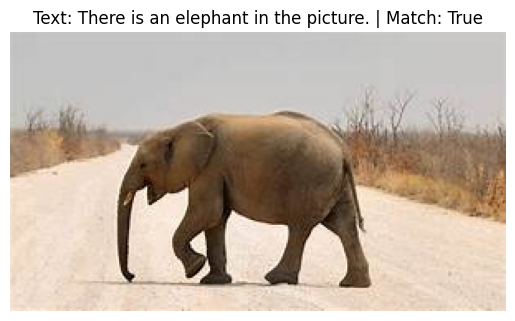

 Text entities: ['squirrel']
 Image prediction: squirrel
 Text: A squirrel is sitting in the park.
 Match result: True


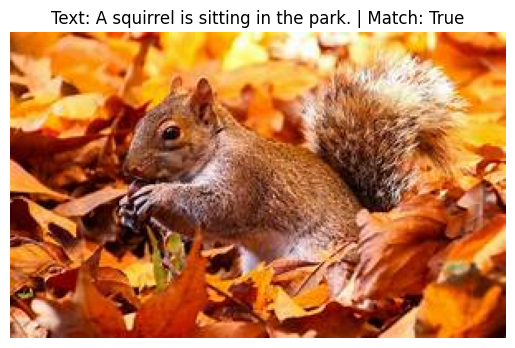

 Text entities: ['dog']
 Image prediction: cat
 Text: This is a dog.
 Match result: False


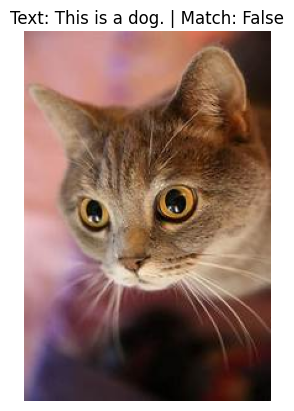

In [16]:
# Run demo cases
demo_case("There is an elephant in the picture.", "/content/animals10/raw-img/elefante/OIP--Sa9RKt5Qlu9I5iQMXkc7wHaEK.jpeg")
demo_case("A squirrel is sitting in the park.", "/content/animals10/raw-img/scoiattolo/OIP--2DLJjX4d5SG0eF_EXsO9AHaEk.jpeg")
demo_case("This is a dog.", "/content/animals10/raw-img/gatto/1002.jpeg")

Test the pipeline with different examples:

- Text: "There is an elephant in the picture."  
- Image: elephant image - **True**

- Text: "A squirrel is sitting in the park."  
- Image: squirrel image - **True**

- Text: "This is a dog."  
- Image: cat image - **False**